network='resnet', dataset='cifar', noreg_val=29.26666666666667
network='resnet', dataset='cifar', noreg_val=29.26666666666667


/tmp/ipykernel_621739/3257233113.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["diff"] = filtered_df["avg_acc_tag"] - noreg_val
/tmp/ipykernel_621739/3257233113.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["diff"] = filtered_df["avg_acc_tag"] - noreg_val


network='resnet', dataset='imagenet', noreg_val=32.666666666666664
network='resnet', dataset='imagenet', noreg_val=32.666666666666664


/tmp/ipykernel_621739/3257233113.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["diff"] = filtered_df["avg_acc_tag"] - noreg_val
/tmp/ipykernel_621739/3257233113.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["diff"] = filtered_df["avg_acc_tag"] - noreg_val


network='convnext', dataset='cifar', noreg_val=29.56666666666667
network='convnext', dataset='cifar', noreg_val=29.56666666666667


/tmp/ipykernel_621739/3257233113.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["diff"] = filtered_df["avg_acc_tag"] - noreg_val
/tmp/ipykernel_621739/3257233113.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["diff"] = filtered_df["avg_acc_tag"] - noreg_val


network='convnext', dataset='imagenet', noreg_val=37.93333333333333
network='convnext', dataset='imagenet', noreg_val=37.93333333333333


/tmp/ipykernel_621739/3257233113.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["diff"] = filtered_df["avg_acc_tag"] - noreg_val
/tmp/ipykernel_621739/3257233113.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["diff"] = filtered_df["avg_acc_tag"] - noreg_val


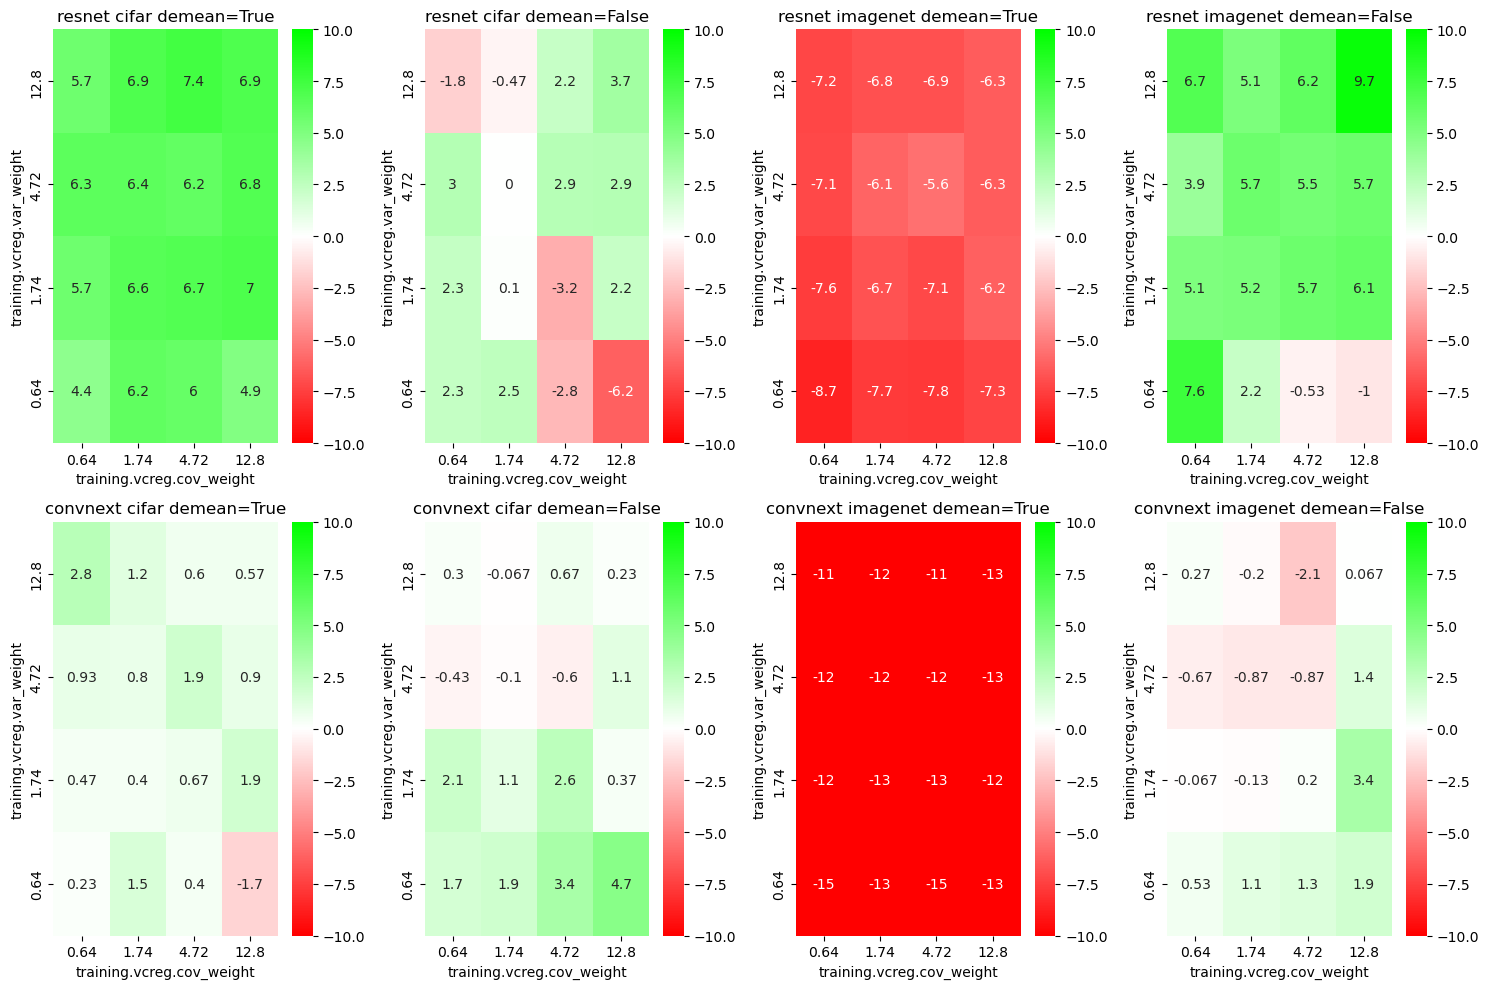

In [10]:
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import wandb

from typing import List, Optional
from itertools import product
from matplotlib import pyplot as plt
import seaborn as sns


# Project is specified by <entity/project-name>
def create_df_from_api(api, project_path):
    runs = api.runs(project_path)

    summary_list, config_list, name_list = [], [], []
    for run in runs:
        if run.state == "running":
            continue
        # .summary contains the output keys/values for metrics like accuracy.
        #  We call ._json_dict to omit large files
        summary_list.append(run.summary._json_dict["test/avg_acc_tag"])

        # .config contains the hyperparameters.
        #  We remove special values that start with _.
        config_list.append(
            {k: v for k, v in run.config.items() if not k.startswith("_")}
        )

        # .name is the human-readable name of the run.
        name_list.append(run.name)

    runs_df = pd.DataFrame(
        {"avg_acc_tag": summary_list, "config": config_list, "name": name_list}
    )

    config_df = pd.json_normalize(runs_df["config"])
    df = pd.concat([runs_df.drop(columns=["config"]), config_df], axis=1)
    df["data.datasets"] = df["data.datasets"].apply(lambda x: x[0])
    return df


def get_df(
    df,
    network: str,
    layer: List[str],
    dataset: str,
    is_scaled: bool,
    noreg_val: Optional[float] = None,
):
    conditions = (
        (df["model.network"].str.contains(network))
        & (df["misc.seed"] == 0)
        & (df["data.datasets"].str.contains(dataset))
        & (df["training.approach.name"] == "finetuning")
        & (df["data.exemplars.num_exemplars"] == 0)
        & (df["data.stop_at_task"] == 3)
        & (df["data.num_tasks"] == 10)
    )
    varcov = conditions & (
        df["training.vcreg.reg_layers"].str.contains("|".join(layer))
        & (df["training.vcreg.scale"] == is_scaled)
    )

    if noreg_val is None:
        noreg = conditions & (df["training.vcreg.reg_layers"].isna())
        noreg_val = df[noreg]["avg_acc_tag"].item()
        print(f"{network=}, {dataset=}, {noreg_val=}")

    filtered_df = df[varcov]
    assert filtered_df.shape[0] == 16
    filtered_df["diff"] = filtered_df["avg_acc_tag"] - noreg_val
    return filtered_df


api = wandb.Api()
# project_path = "tunnels-ssl/07.08"
# df1 = create_df_from_api(api, project_path)
project_path = "tunnels-ssl/07.04"
df2 = create_df_from_api(api, project_path)

df = df2
# df2 = df2[df2["training.vcreg.reg_layers"].isna()]
# df = pd.concat((df1, df2))


layers = {
    "last_layer": ["fc", "classifier"],
    "intermediate": ["after_relu", "after_skipping"],
}
colors = [(1, 0, 0), (1, 1, 1), (0, 1, 0)]
cmap = LinearSegmentedColormap.from_list("custom_cmap", list(colors), N=256)


networks = ["resnet", "convnext"]
datasets = ["cifar", "imagenet"]
layer = layers["intermediate"]
is_scaled = [True, False]
n_rows = len(networks)
n_cols = len(is_scaled) * len(datasets)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))

axes = axes.flatten()

for ax, (network, dataset, scaled) in zip(axes, product(networks, datasets, is_scaled)):
    # Get the DataFrame for the specific network and layer

    p = get_df(df, network, layer, dataset, scaled).pivot(
        index="training.vcreg.var_weight",
        columns="training.vcreg.cov_weight",
        values="diff",
    )
    # Plot the heatmap on the current axis
    sns.heatmap(p, annot=True, ax=ax, vmin=-10, vmax=10, cmap=cmap)
    ax.invert_yaxis()
    ax.set_title(" ".join([network, dataset, f"demean={scaled}"]))

# Adjust layout
plt.tight_layout()
plt.show()

In [2]:
# project_path = "tunnels-ssl/07.08"
# df1 = create_df_from_api(api, project_path)
project_path = "tunnels-ssl/07.18"
convnext_left = create_df_from_api(api, project_path)

## intermediate + last convenxt imagent lower cov weight

In [18]:
def get(df):
    conditions = (
        (df["model.network"].str.contains("convnext"))
        & (df["misc.seed"] == 0)
        & (df["data.datasets"].str.contains("imagenet"))
        & (df["training.approach.name"] == "finetuning")
        & (df["data.exemplars.num_exemplars"] == 0)
        & (df["data.stop_at_task"] == 3)
        & (df["data.num_tasks"] == 10)
    )

    return df[conditions]


df = get(convnext_left)[
    ["avg_acc_tag", "training.vcreg.var_weight", "training.vcreg.cov_weight"]
]
df["avg_acc_tag"] -= 37.93333333333333
df

,avg_acc_tag,training.vcreg.var_weight,training.vcreg.cov_weight
80,-9.666667,25.60,0.32
81,-9.533333,12.80,0.32
82,-8.866667,4.72,0.32
83,-10.200000,1.74,0.32
84,-10.200000,0.64,0.32
